<h1>台積電擴大赴美投資情緒分析2</h1>

## 1. 套件安裝

In [ ]:
# 安裝會使用到的套件
# 安裝ckiptagger前要先安裝tensorflow，有套件相依的問題
# %pip install -U ckiptagger\[tf,gdown\]
# %pip install wordcloud SnowNLP

In [ ]:
# 確認當前工作目錄
# %pwd

In [2]:
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import re
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import os
import opencc

In [3]:
# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] # MacOS 內建中文字體
# plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # Windows 中文字體

## 2. CKIP

### 2.1 CKIP安裝

In [ ]:
# data_utils.download_data_gdown("./")  # 下載ckip model

### 2.2 利用CKIP進行自然語言處理
透過ckip這個套件可以對文集進行斷詞、命名實體辨識、詞性標記等處理
+ CKIP 標註任務
    + 斷詞（ws）
        + 可以設定自己的辭典
            + `recommend_dictionary` 推薦字典
            + `coerce_dictionary` 強制字典
    + 實體辨識（ner）
    + 詞性標註（pos）
+ NER與POS名詞對應: https://ckip.iis.sinica.edu.tw/service/corenlp/ （左上角的標記列表）

In [4]:
# 將三份工具的模型路徑指向我們剛才下載的檔案「data」
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

/Users/yolun/SMA_2025S/.venv/lib/python3.11/site-packages/ckiptagger/model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
2025-03-21 16:15:01.695905: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
/Users/yolun/SMA_2025S/.venv/lib/python3.11/site-packages/ckiptagger/model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
/Users/yolun/SMA_2025S/.venv/lib/python3.11/site-packages/ckiptagger/model_ner.py:57: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future 

## 3. CKIP 標註

### 3.1 將抓取結果用CKIP進行處理
<h3>資料簡介</h3>
<ul>
<li>資料來源:PTT-stock版文章</li>
<li>爬取工具:tarflow工具</li>
<li>關鍵字:台積電,美積電,亞利桑那</li>
<li>取用期間:2024/10/01~2025/3/12</li>  
<li>文章筆數:2,546</li>
</ul>

In [5]:
## 讀取文章
df = pd.read_csv('./raw_data/program1.csv')
# 確保 artDate 欄位為字串，避免雜訊
df["artDate"] = df["artDate"].astype(str).str.strip()
# 嘗試轉換日期，錯誤的值變成 NaT
df["artDate"] = pd.to_datetime(df["artDate"], errors="coerce")
# 檢查無效日期
#print("無效日期數量:", df["artDate"].isna().sum())
# 查看無效日期的前 20 筆
#invalid_dates = df[df["artDate"].isna()]
#print(invalid_dates[["artDate"]].head(20))
# 選擇是否要刪除無效日期
df = df.dropna(subset=["artDate"])
print("artDate 已成功轉換，合併後的 DataFrame：")
df["artDate"] = df["artDate"].dt.date
df.head(3)

artDate 已成功轉換，合併後的 DataFrame：


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,Lefty,Stock,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...","[{""cmtStatus"": ""推"", ""cmtPoster"": ""kkes0001"", ""...",180.177.26.33,2024/9/2 2:03,ptt
1,2,https://www.ptt.cc/bbs/Stock/M.1725197370.A.1F...,[標的]大盤跟外資喊話多,2024-09-01,derrengay,Stock,帕拉迪島=台灣\n\n調查兵團=台積電\n\n艾倫=張忠謀\n\n我在這邊公開跟會看PTT的...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""xxgogg"", ""cm...",112.78.86.207,2024/9/2 2:03,ptt
2,3,https://www.ptt.cc/bbs/Stock/M.1725198616.A.9A...,[新聞]黑悟空帶飛台灣PC、遊戲股？鈊象、大宇,2024-09-01,cjol,Stock,黑悟空帶飛台灣PC、遊戲股？鈊象、大宇資、宇峻齊紅！智崴漲近半根\n\n\nFTNN新聞網\...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""st9061204"", ...",122.117.2.178,2024/9/2 2:03,ptt


定義文字清理的相關function

In [6]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

import re

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ 
    Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 確保 article 為字串，避免浮點數導致錯誤
    2. 去除(\\n)
    3. 去除特殊符號字元
    4. 保留數字 (選擇性)
    5. 保留字母 (選擇性)
    6. 依照斷句字元進行斷句，全形的分號、逗號、句號、問號以及驚嘆號
    7. 避免空白斷句結果

    Args:
        article (str): 欲斷行之文章內容
        keep_digits (bool): 決定是否保留數字於斷行後的結果
        keep_alphabets (bool): 決定是否保留字母於斷行後的結果
    Returns:
        list: 每個 element 就是一行
    """
    # 確保 article 為字串，避免 float 產生錯誤
    article = str(article) if article is not None else ""

    # 定義特殊符號與斷句標點
    special_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")

    # 過濾掉空白段落（確保非空白）
    paragraphs = list(filter(lambda x: re.sub(r'\s+', '', x), article.split("\n")))

    result = []
    for paragraph in paragraphs:
        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+', '', clean_paragraph)  # 移除數字
            if not keep_alphabets:
                clean_paragraph = re.sub(r'[a-zA-Z]+', '', clean_paragraph)  # 移除英文字母

            clean_paragraph = re.sub(r'[\s]+', '', clean_paragraph)  # 移除多餘空白
            clean_paragraph = re.sub(special_symbols, '', clean_paragraph)  # 移除特殊符號
            
        except Exception as e:
            return f"error: {e}"

        # 執行斷句
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)

    return result


CKIP 處理相關function

In [12]:
with open('./raw_data/dict/user_dict.txt') as f:
    lines = f.read().splitlines()

dict = {k.split()[0]: k.split()[1] for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(dict)
print(dictionary2)


[(1, {'漲': 500.0, '勝': 500.0, '褒': 500.0, '謝': 500.0, '遲': 500.0, '跌': 500.0, '奪': 500.0, '貪': 500.0, '壞': 500.0, '敗': 500.0, '宰': 500.0, '殺': 500.0, '騙': 500.0, '俗': 500.0, '差': 500.0, '愁': 500.0, '呆': 500.0, '亂': 500.0, '罵': 500.0, '熬': 500.0, '逼': 500.0}), (2, {'安定': 500.0, '安康': 500.0, '幫助': 500.0, '榜樣': 500.0, '飽滿': 500.0, '保證': 500.0, '標杆': 500.0, '才思': 500.0, '喜兆': 500.0, '彩頭': 500.0, '昌盛': 500.0, '超越': 500.0, '稱讚': 500.0, '成功': 500.0, '成果': 500.0, '成就': 500.0, '誠懇': 500.0, '充裕': 500.0, '充足': 500.0, '寵愛': 500.0, '創新': 500.0, '創業': 500.0, '創造': 500.0, '促進': 500.0, '大量': 500.0, '大師': 500.0, '到達': 500.0, '得益': 500.0, '典範': 500.0, '獨家': 500.0, '恩惠': 500.0, '發明': 500.0, '發展': 500.0, '繁榮': 500.0, '豐富': 500.0, '改進': 500.0, '改良': 500.0, '改善': 500.0, '高手': 500.0, '高效': 500.0, '高新': 500.0, '高興': 500.0, '革新': 500.0, '公平': 500.0, '公正': 500.0, '恭喜': 500.0, '鞏固': 500.0, '鼓勵': 500.0, '鼓舞': 500.0, '好處': 500.0, '好的': 500.0, '合意': 500.0, '合作': 500.0, '恆心': 500.0, '歡呼': 500.0, '緩和': 500.0, '回升': 5

In [13]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
    # print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id, word, pos]) 
    # print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
    # print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3], entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    # 遍歷 dataframe 的每筆資料
    for index, row in data_df.iterrows(): # document level    
    # print(f"\ndocument {index}") 

        # 資料清理 ＆ 斷句
        tmp = Sentence_Segmentation(row['artContent']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2)
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        # 遍歷該 document 中的每一個句子
        for i, sentence in enumerate(flat_list):
            # print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'], sentence])            
            temp_tokens = get_pos(row['system_id'], word_sentence_list[i], pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'], entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['system_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['system_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['system_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [14]:
# 看看 tmp 和 flat_list 有什麼差別
tmp = Sentence_Segmentation(df['artContent'][0]) 
flat_list = [item for sublist in tmp for item in sublist]
print(tmp[:5])
print(flat_list[:5])

[['標的'], ['台積電'], ['分類多'], ['分析/正文'], ['今年第三季靠近尾端了,打些第四季或明年展望的部分']]
['標的', '台積電', '分類多', '分析/正文', '今年第三季靠近尾端了,打些第四季或明年展望的部分']


In [17]:
pos_table, entity_table, sentence_table = get_nlp_result(df)

time costing: 621.3056330680847


+ 欄位名稱介紹
    + pos_table 欄位:
        + system_id : ptt 貼文id
        + word: 原始斷詞
        + pos : part-of-speech,詞性
    + entity_table 欄位:
        + system_id : ptt 貼文id
        + word: 原始斷詞
        + ner: 命名實體
    + sentence_table 欄位:
        + system_id : ptt 貼文id
        + text: 原始斷句

In [18]:
pos_table.head() # word pos 列表

,system_id,word,pos
0,1,標的,Na
1,1,台積電,Nb
2,1,分類,Na
3,1,多,VH
4,1,分析,VC


In [19]:
entity_table.head() # word entity 列表

,system_id,word,ner
0,1,台積電,ORG
1,1,今年第三季,DATE
2,1,第四,ORDINAL
3,1,明年,DATE
4,1,第三,ORDINAL


In [20]:
sentence_table.head()

,system_id,sentence
0,1,標的
1,1,台積電
2,1,分類多
3,1,分析/正文
4,1,"今年第三季靠近尾端了,打些第四季或明年展望的部分"


In [21]:
# 檢查筆數
print(f"total posts numbers: {len(pos_table['system_id'].unique())}") # 1628篇文
print(f"posts have NER: {len(entity_table['system_id'].unique())}") # 1620篇有抓到ner

total posts numbers: 2541
posts have NER: 2534


In [22]:
# 將文章存成csv
pos_table.to_csv('./raw_data/zh/pos_table_buffet.csv', index = False)
entity_table.to_csv('./raw_data/zh/entity_table_buffet.csv', index = False)
sentence_table.to_csv('./raw_data/zh/sentence_table_buffet.csv', index = False)

### 3.2 探索分析 - NER

將剛才分析的資料匯入

In [23]:
# 讀取已經執行完畢的結果
pos_table = pd.read_csv("raw_data/zh/pos_table_buffet.csv") 
entity_table = pd.read_csv("raw_data/zh/entity_table_buffet.csv") 
sentence_table = pd.read_csv("raw_data/zh/sentence_table_buffet.csv") 

### NER 種類分析
查看標註這個文集後辨識出哪一些實體種類<br>
名詞對應: https://ckip.iis.sinica.edu.tw/service/corenlp/ （左上角的標記列表）

In [24]:
entity_table['ner'].unique()

array(['ORG', 'DATE', 'ORDINAL', 'PERSON', 'NORP', 'LOC', 'TIME', 'GPE',
       'CARDINAL', 'MONEY', 'PRODUCT', 'WORK_OF_ART', 'EVENT', 'QUANTITY',
       'FAC', 'LANGUAGE', 'PERCENT', 'LAW'], dtype=object)

In [25]:
ner_count = entity_table.groupby(['ner'])['ner'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(10)
ner_count

,ner,count
11,ORG,31945
4,GPE,15150
13,PERSON,11376
1,DATE,7704
0,CARDINAL,3345
8,MONEY,2244
9,NORP,2006
10,ORDINAL,1098
7,LOC,872
16,TIME,458


Text(0.5, 0, 'Frequency')

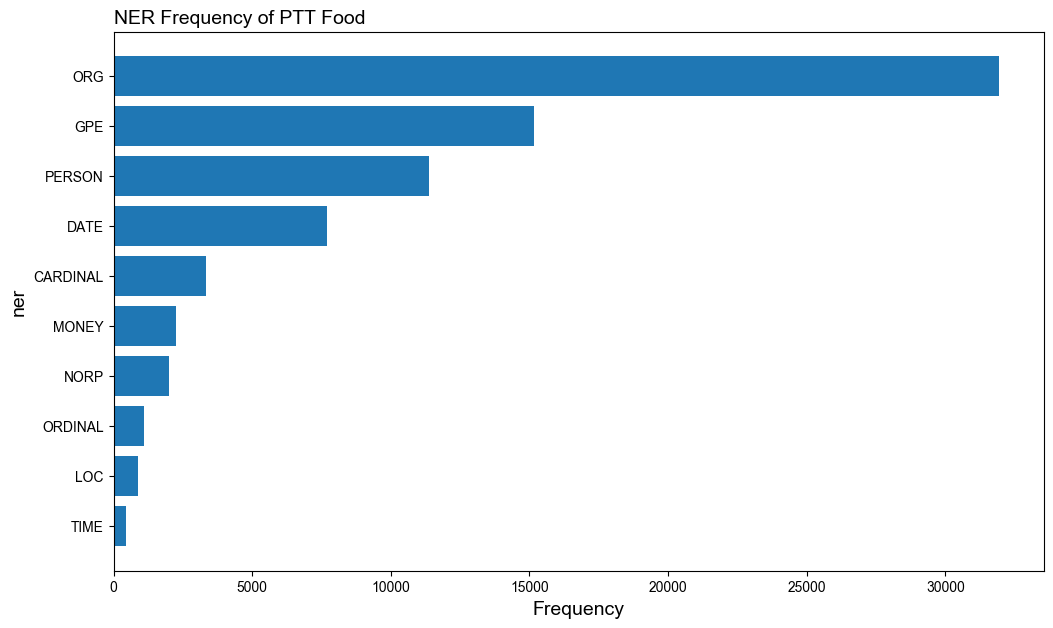

In [ ]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency of PTT Stock',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
# fig.show()

### 涉及到的民族、宗教、政治團體(NORP)

Text(0.5, 0, 'Word Frequency')

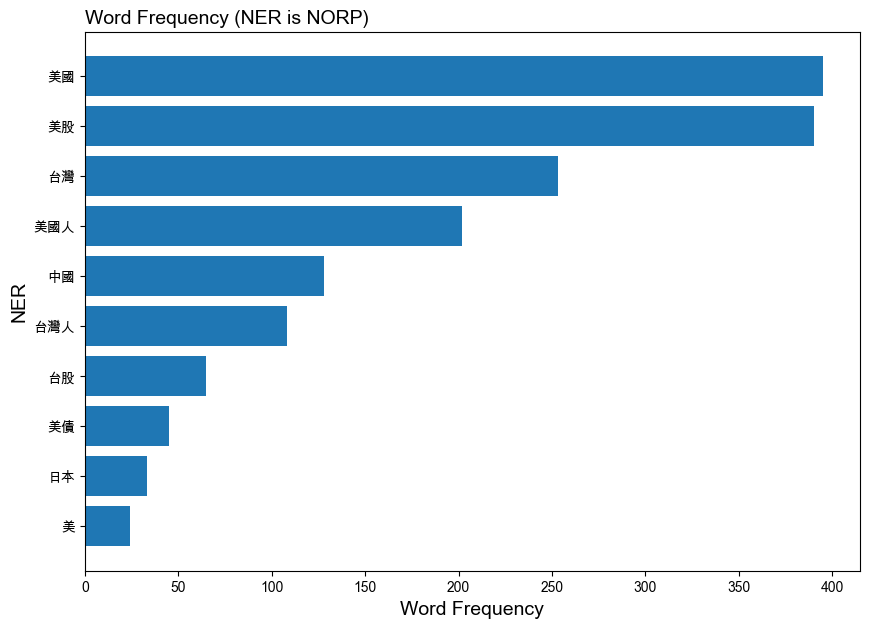

In [27]:
# 篩選ner為NORP的資料
l_noun = ["NORP"]
NORP = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = NORP.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is NORP)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
# fig.show()

### 涉及到的組織(ORG)

Text(0.5, 0, 'Word Frequency')

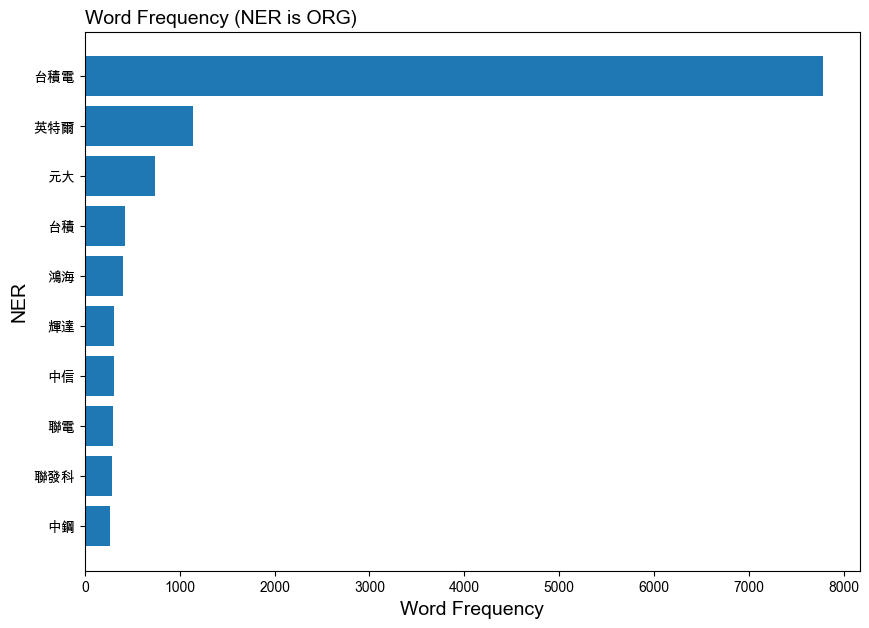

In [28]:
# 篩選ner為ORG的資料
l_noun = ["ORG"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
# fig.show()

### 涉及到的人名(PERSON)

Text(0.5, 0, 'Word Frequency')

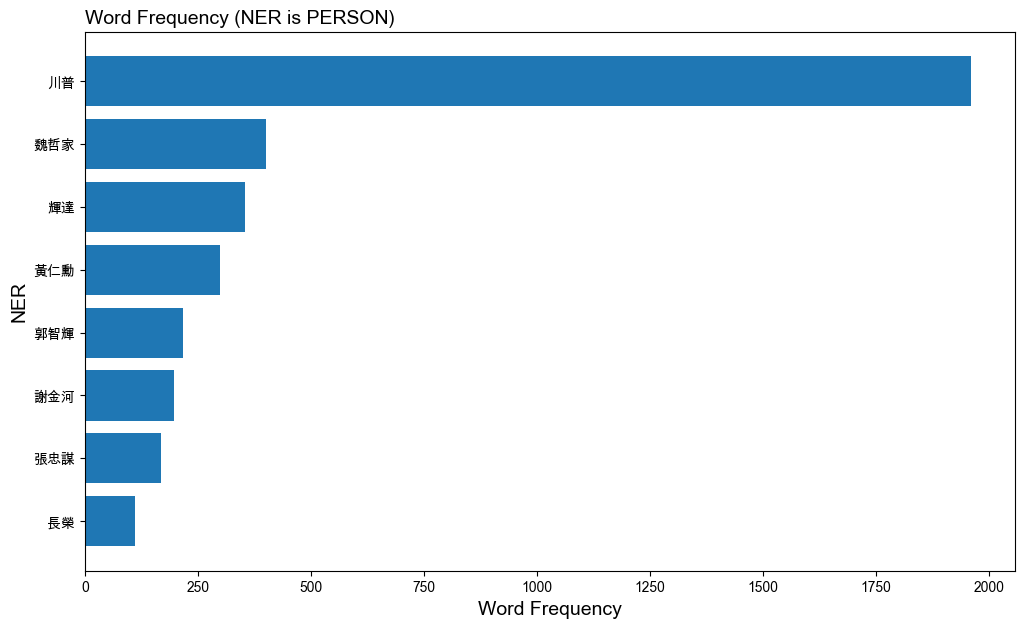

In [29]:
# 篩選ner為PERSON的資料
l_noun = ["PERSON"]
PERSON = entity_table[entity_table.ner.isin(l_noun)]

# 計算每個名詞提到的次數，選出前8個
ner_count = PERSON.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(8).reset_index()

# 設定中文字形
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
# fig.show()

下面找出「台積電」相關文章，與後續情緒分析一起做探索

In [30]:
keyword_list = ['台積電']
shu_selected = df[df['artContent'].str.contains('|'.join(keyword_list), regex=True, na=False)]
print(f"{' '.join(keyword_list)}：{shu_selected.shape[0]}篇相關貼文")
shu_selected.head(3)


台積電：2379篇相關貼文


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,Lefty,Stock,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...","[{""cmtStatus"": ""推"", ""cmtPoster"": ""kkes0001"", ""...",180.177.26.33,2024/9/2 2:03,ptt
1,2,https://www.ptt.cc/bbs/Stock/M.1725197370.A.1F...,[標的]大盤跟外資喊話多,2024-09-01,derrengay,Stock,帕拉迪島=台灣\n\n調查兵團=台積電\n\n艾倫=張忠謀\n\n我在這邊公開跟會看PTT的...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""xxgogg"", ""cm...",112.78.86.207,2024/9/2 2:03,ptt
2,3,https://www.ptt.cc/bbs/Stock/M.1725198616.A.9A...,[新聞]黑悟空帶飛台灣PC、遊戲股？鈊象、大宇,2024-09-01,cjol,Stock,黑悟空帶飛台灣PC、遊戲股？鈊象、大宇資、宇峻齊紅！智崴漲近半根\n\n\nFTNN新聞網\...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""st9061204"", ...",122.117.2.178,2024/9/2 2:03,ptt


### 3.3 探索分析 - POS

#### POS 種類分析
查看辨識出哪幾種POS<br>
名詞對應: https://ckip.iis.sinica.edu.tw/service/corenlp/ （左上角的標記列表）

In [31]:
pos_table['pos'].unique()

array(['Na', 'Nb', 'VH', 'VC', 'FW', 'Nd', 'Neu', 'Ncd', 'T',
       'COMMACATEGORY', 'Nf', 'Caa', 'VJ', 'DE', 'Neqa', 'Da', 'VCL', 'P',
       'Cbb', 'VE', 'D', 'VA', 'SHI', 'Dfa', 'Nc', 'VD', 'VL', 'V_2',
       'Ng', 'Di', 'Nes', 'VB', 'VG', 'Cab', 'VHC', 'Nep', 'VK', 'Nh',
       'Cba', 'VAC', 'A', 'Nv', 'VF', 'Dfb', 'DM', 'Dk', 'VI', 'I',
       'Neqb', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'],
      dtype=object)

看看除了標點符號，大部分的POS都是哪一類

In [32]:
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(12)
pos_count

,pos,count
15,Na,155268
5,D,60055
35,VC,52073
16,Nb,46090
41,VH,42365
17,Nc,39384
29,P,25759
6,DE,22996
38,VE,16903
25,Nf,14966


#### POS 常見詞性列表
+ Na: 普通名詞
+ D: 副詞
+ VC: 動作及物動詞
+ Nb: 專有名詞
+ FW: 外文
+ VH: 狀態不及物動詞
+ Nh: 代名詞
+ DE: 的之得地
+ P: 介詞
+ VA: 動作不及物動詞
+ T: 語助詞
+ SHI: 是

/var/folders/4j/vnt4rb296dx964cnmwf04t280000gn/T/ipykernel_1016/2478466374.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


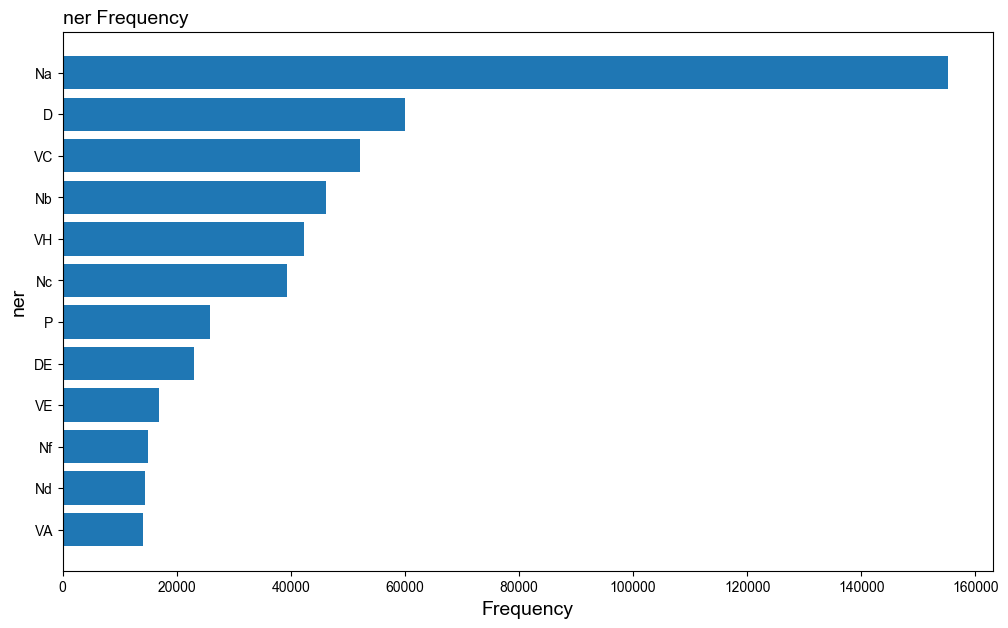

In [33]:
pos = pos_count['pos']
count = pos_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('ner Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

### 涉及到的名詞(Noun)
+ 我們可以找出談論台積電時大部分討論到的名詞，探索大家的關注焦點。
+ 名詞可以分為「Na: 普通名詞」、「Nb: 專有名詞」等

In [34]:
# 篩選pos為專有名詞的資料
l_noun = ["Nb"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]

# 計算每個名詞提到的次數，選出前15個
noun_count = noun[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
noun_count.head(10)

,word,count
598,台積電,8521
1348,張,2347
1144,川普,2109
2981,英特爾,1252
300,元大,962
3370,輝達,778
586,台積,686
4015,鴻海,618
807,國泰,603
22,三星,538


/var/folders/4j/vnt4rb296dx964cnmwf04t280000gn/T/ipykernel_1016/488784228.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


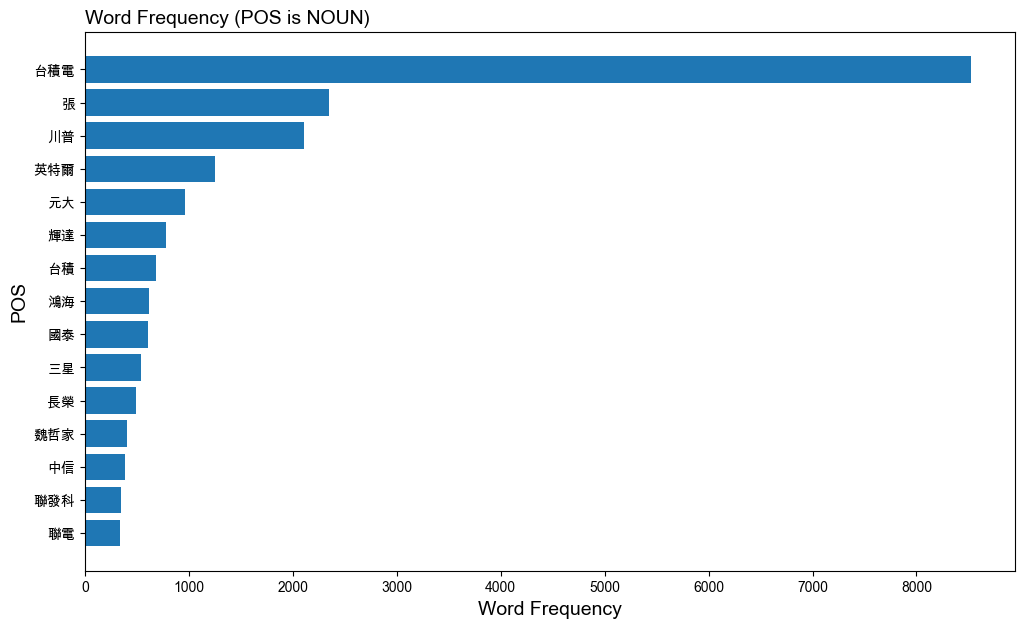

In [35]:
# 設定中文字形
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is NOUN)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

可以看到台積電依舊是出現最多次的專有名詞，另外，從「川普」、「英特爾」和「輝達」等專有名詞可以看出對於台積電競爭對手與客戶等詞有較高的討論度。

### 涉及到的動詞(VERB)
+ 我們可以找出近期談論台積電時大部分討論到的動詞，與海外投資、擴廠等相關行為。
+ VC: 動作及物動詞、VH: 狀態不及物動詞、VA: 動作不及物動詞

In [36]:
l_verb = ["VC"] # ,"VH","VA"
verb = pos_table[pos_table.pos.isin(l_verb)] # 選取特定詞性
verb = verb[verb['word'].map(len) > 1] # 把長度為1的字去除掉

verb_count = verb[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
verb_count

,word,count
1201,投資,1876
2195,發布,831
3139,連結,771
2697,製造,722
2516,署名,709
2194,發展,583
2145,生產,502
309,分析,445
1033,影響,420
870,封裝,398


/var/folders/4j/vnt4rb296dx964cnmwf04t280000gn/T/ipykernel_1016/29217454.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


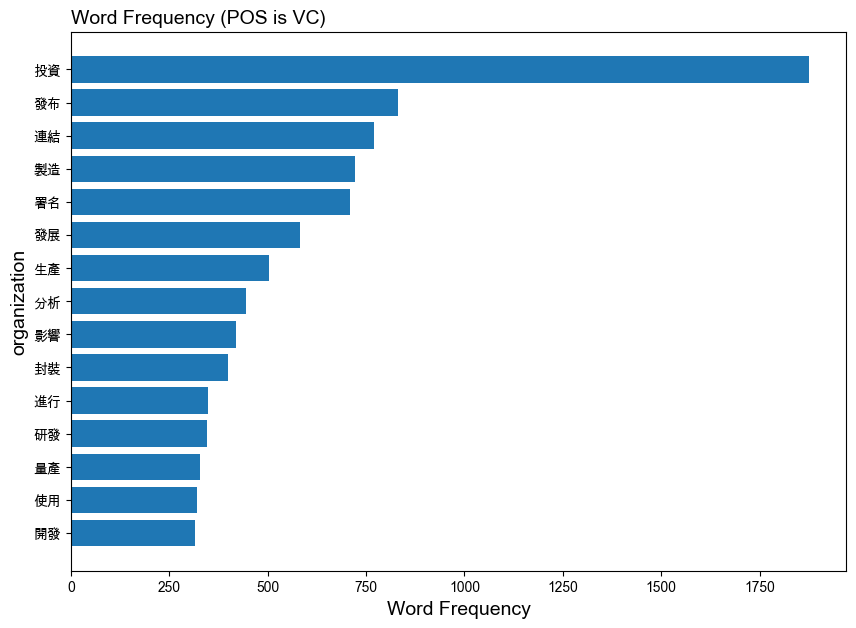

In [37]:
word = verb_count['word']
count = verb_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is VC)',loc ='left', size = 14)
ax.set_ylabel('organization', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

發現在貼文中的動詞，「投資」佔了相當高的頻率，其他還有「發布」、「製造」等詞彙，可推測民眾對資訊公告較感興趣。

## 4. 利用SnowNLP進行情緒分析

+ SnowNLP 針對中文設計，可以提取句子的情緒分類
+ 使用文件分類法，套件已預先用文集訓練模型以判斷情緒
+ 情緒值在 0~1之間，代表負面到正面
+ 官方github: https://github.com/isnowfy/snownlp

In [38]:
from snownlp import SnowNLP
s = SnowNLP('投資掏空了台灣')
s.sentiments # 範圍在 0~ 1之間 (負面~正面)

0.15310187703651312

使用先前NER得到的「台積電」相關文章，看看台積電相關文章的情緒表現。<br>
首先將句子和日期合併，方便之後做分析

In [40]:
sentence_table = pd.read_csv("raw_data/zh/sentence_table_buffet.csv") #匯資料

sentence_table["system_id"] = sentence_table["system_id"].astype(str)
shu_selected["system_id"] = shu_selected["system_id"].astype(str)

sentiment_date = pd.merge(
    sentence_table, 
    shu_selected[['system_id','artDate','dataSource']], 
    on='system_id', 
    how='left'
).dropna()

sentiment_date.head(3)


/var/folders/4j/vnt4rb296dx964cnmwf04t280000gn/T/ipykernel_1016/1795761888.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shu_selected["system_id"] = shu_selected["system_id"].astype(str)


,system_id,sentence,artDate,dataSource
0,1,標的,2024-09-01,ptt
1,1,台積電,2024-09-01,ptt
2,1,分類多,2024-09-01,ptt


In [41]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head(3)

,system_id,sentence,artDate,dataSource,sentimentValue
0,1,標的,2024-09-01,ptt,0.272727
1,1,台積電,2024-09-01,ptt,0.454011
2,1,分類多,2024-09-01,ptt,0.250783


In [42]:
# 看一下情緒的分布
sentiment_date['sentimentValue'].describe()

count    8.563000e+04
mean     4.460186e-01
std      3.134739e-01
min      5.384362e-10
25%      1.563315e-01
50%      4.678584e-01
75%      7.053839e-01
max      9.999999e-01
Name: sentimentValue, dtype: float64

<Axes: >

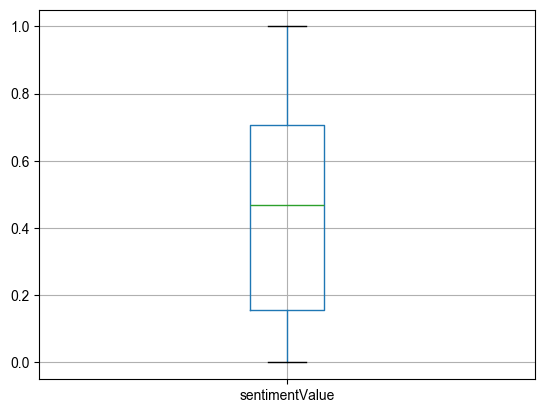

In [43]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

將每個月的情緒分數取平均，並轉換時間格式為年月

In [44]:
sent_date = sentiment_date.copy()
sent_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.to_period('M')

sentiment_count = sent_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()
sentiment_count

,artDate,sentimentValue
0,2024-09,0.446351
1,2024-10,0.447556
2,2024-11,0.453963
3,2024-12,0.450672
4,2025-01,0.425419
5,2025-02,0.450387
6,2025-03,0.449867


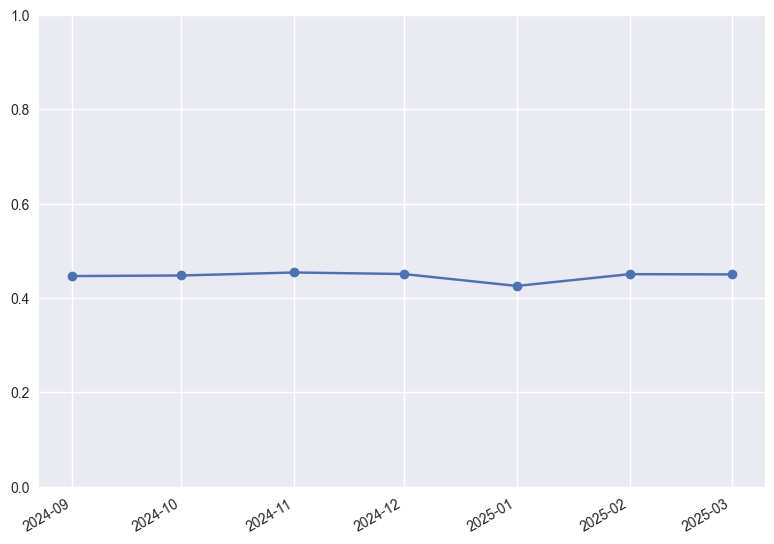

In [45]:
# 平均情緒分數時間趨勢
months = [period.to_timestamp() for period in sentiment_count['artDate']]   # 將 PeriodIndex 中的每個 Period 物件轉換為對應的 datetime 物件
y = sentiment_count['sentimentValue']

plt.style.use('seaborn-v0_8')

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.ylim(0, 1)

plt.show()

從上圖中發現大部分天數的情緒值都在0.4~0.5之間，偏向中性。

### 詞彙探索
觀察2025年3月的情緒分數，我們把這個月的正面句子挑出來看看他們都用甚麼詞。

In [46]:
# 篩時間
filter_sentiment = sent_date[sent_date['artDate']=='2025-03']
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] > 0.7]

filter_sentiment.head()

,system_id,sentence,artDate,dataSource,sentimentValue
83617,2187,員今天表示，台積電去美國設廠就會變美積電這是對產業失學程度的理解,2025-03,ptt,0.924363
83620,2187,事實證明反而讓產業更壯大,2025-03,ptt,0.728632
83622,2187,應鏈優勢，技術持續領先是關鍵,2025-03,ptt,0.850302
83625,2187,立場社群，甚至出現整個新竹科學園區都要搬到美國等離譜說法,2025-03,ptt,0.762235
83627,2187,國際常識,2025-03,ptt,0.708592


In [47]:
# 轉換 system_id 為字串，確保資料型態一致
filter_sentiment["system_id"] = filter_sentiment["system_id"].astype(str)
pos_table["system_id"] = pos_table["system_id"].astype(str)
# 把時間分數和之前斷詞的 token table 做 join
pos_words = pd.merge(filter_sentiment,pos_table,on='system_id',how='left')
pos_words = pos_words[['system_id','sentimentValue','word']]
pos_words.head()

,system_id,sentimentValue,word
0,2187,0.924363,原文
1,2187,0.924363,標題
2,2187,0.924363,台積電
3,2187,0.924363,變
4,2187,0.924363,美積電


In [48]:
# 篩選掉只有單個字元的結果
pos_words = pos_words[pos_words.apply(lambda x: len(x['word'])>1, axis=1)]

### 正面詞彙文字雲

In [49]:
# 自定停用字
with open('./raw_data/dict/stopwords.txt') as f:
    stop_words = f.read().splitlines()

print(stop_words[:20])

['$', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', '_', '“', '”', '、', '。', '《', '》', '一']


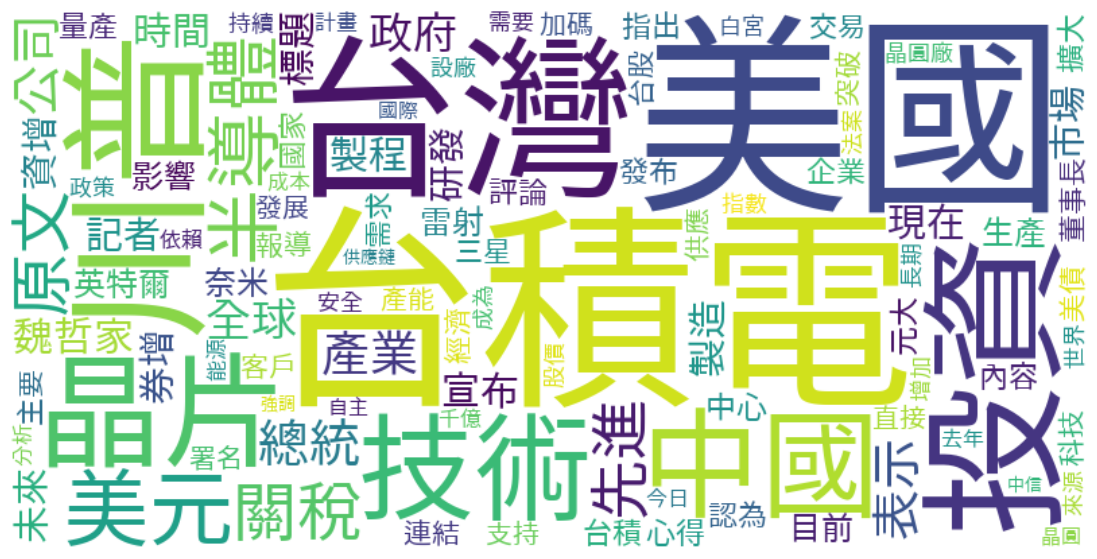

In [50]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
stop_words_pos.extend(('問題', '控制', '擔心', '錯過', '隨便', '強烈', '負擔', '口吃', '挑剔', '壓力', '邪惡', '禁止',
                   '挑戰', '謝謝', '智能', '智慧'))
stop_words_pos = set(stop_words_pos)

# 設定中文字形
Font_Path = 'TaipeiSansTCBeta-Regular.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,
                collocations=False,
                font_path=Font_Path,
                width=800, 
                height = 400, 
                max_words=100, 
                background_color="white")

wordcloud.generate(' '.join(pos_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

情緒分數>0.7的正向文章中，對於「技術」、「關稅」、「投資」等議題探討，都具有正面評價，但本組討論後認為，台積電擴大赴美投資議題本來就有正、反兩方的文章，若我們把情緒分數設定在<3.0的條件，得到的文字雲應該也是相同的結果。
以下為分數<3.0的結果:

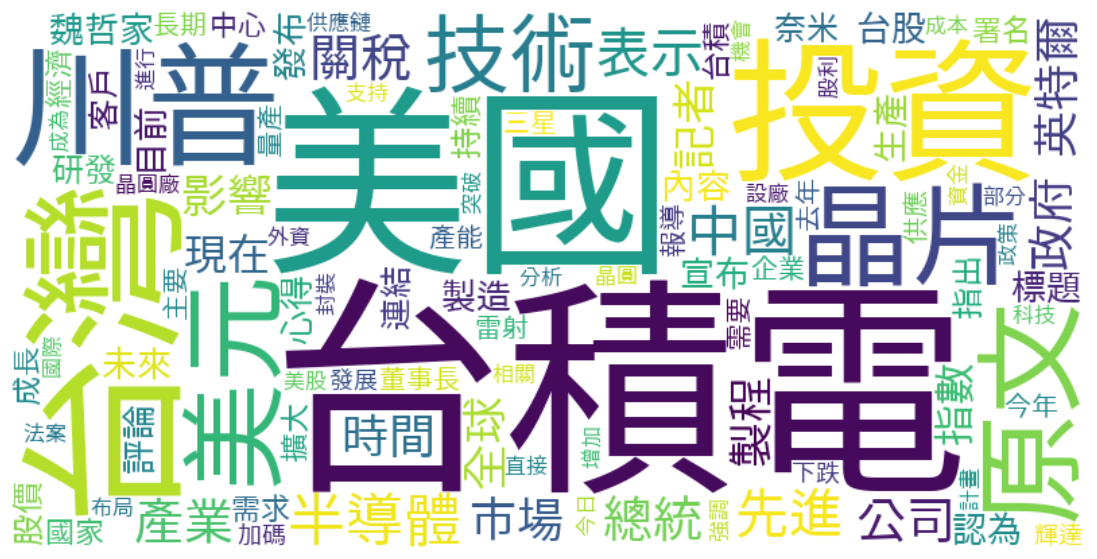

In [51]:
# 篩時間
filter_sentiment2 = sent_date[sent_date['artDate']=='2025-03']
filter_sentiment2 = filter_sentiment2.loc[filter_sentiment2['sentimentValue'] < 0.3]
filter_sentiment2.head()
# 轉換 system_id 為字串，確保資料型態一致
filter_sentiment2["system_id"] = filter_sentiment2["system_id"].astype(str)
pos_table["system_id"] = pos_table["system_id"].astype(str)
# 把時間分數和之前斷詞的 token table 做 join
pos_words2 = pd.merge(filter_sentiment2,pos_table,on='system_id',how='left')
pos_words2 = pos_words2[['system_id','sentimentValue','word']]
pos_words2.head()

# 篩選掉只有單個字元的結果
pos_words2 = pos_words2[pos_words2.apply(lambda x: len(x['word'])>1, axis=1)]
wordcloud.generate(' '.join(pos_words2['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()